In [2]:
from analysis.datasets import load_entsoe
from analysis.transformations import minute_to_daily_50Hertz

C:\Users\Manuel\Documents\Masterarbeit\src\analysis\first_analysis.py:207: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, pdf, 'r-', label=f'Normal Fit\n$\mu={mean:.2f}$, $\sigma={std:.2f}$')
C:\Users\Manuel\Documents\Masterarbeit\src\analysis\first_analysis.py:207: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, pdf, 'r-', label=f'Normal Fit\n$\mu={mean:.2f}$, $\sigma={std:.2f}$')


In [3]:
df = load_entsoe()
df

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)


,offshore,onshore,wind_speed_10m_51.84534_13.656307,wind_speed_10m_51.98594_13.045872,wind_speed_10m_52.26713_11.312384,wind_speed_10m_mean,wind_speed_10m_52.618626_12.761193,wind_speed_10m_52.829525_11.6510315,wind_speed_10m_52.97012_12.372882,wind_speed_10m_53.110718_12.079395,wind_speed_10m_53.18102_11.761364,wind_speed_10m_53.321613_13.859315,wind_speed_10m_53.46221_13.7404585,wind_speed_100m_51.84534_13.656307,wind_speed_100m_51.98594_13.045872,wind_speed_100m_52.26713_11.312384,wind_speed_100m_mean,wind_speed_100m_52.618626_12.761193,wind_speed_100m_52.829525_11.6510315,wind_speed_100m_52.97012_12.372882,wind_speed_100m_53.110718_12.079395,wind_speed_100m_53.18102_11.761364,wind_speed_100m_53.321613_13.859315,wind_speed_100m_53.46221_13.7404585
time,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,21.0,1428.0,2.4800,2.410,2.4800,1.9400,1.8600,1.8400,1.8000,1.9700,1.800,1.9000,2.2000,5.0500,5.160,5.710,4.5200,4.330,5.020,4.4700,4.8600,5.0000,3.7200,4.2700
2016-01-01 00:15:00,27.0,1379.0,2.5525,2.445,2.5150,1.9550,1.8950,1.8925,1.7950,1.9625,1.780,1.9300,2.2100,5.1675,5.245,5.775,4.5625,4.365,5.075,4.4725,4.8250,4.9575,3.7550,4.2975
2016-01-01 00:30:00,24.0,1399.0,2.6250,2.480,2.5500,1.9700,1.9300,1.9450,1.7900,1.9550,1.760,1.9600,2.2200,5.2850,5.330,5.840,4.6050,4.400,5.130,4.4750,4.7900,4.9150,3.7900,4.3250
2016-01-01 00:45:00,20.0,1448.0,2.6975,2.515,2.5850,1.9850,1.9650,1.9975,1.7850,1.9475,1.740,1.9900,2.2300,5.4025,5.415,5.905,4.6475,4.435,5.185,4.4775,4.7550,4.8725,3.8250,4.3525
2016-01-01 01:00:00,16.0,1517.0,2.7700,2.550,2.6200,2.0000,2.0000,2.0500,1.7800,1.9400,1.720,2.0200,2.2400,5.5200,5.500,5.970,4.6900,4.470,5.240,4.4800,4.7200,4.8300,3.8600,4.3800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 22:00:00,1294.0,12728.0,5.2600,5.960,6.0500,5.6600,6.0400,6.4400,6.6500,7.0700,6.660,6.7200,7.1500,9.7800,10.670,10.610,9.9400,10.320,11.050,11.1200,11.7500,11.1700,11.0000,11.5700
2024-12-31 22:15:00,1386.0,13012.0,5.3600,6.035,6.0825,5.6175,6.0325,6.5900,6.6575,7.0800,6.665,6.7725,7.1225,9.9125,10.765,10.630,9.9450,10.350,11.170,11.1150,11.6925,11.1050,11.1175,11.5975
2024-12-31 22:30:00,1397.0,13278.0,5.4600,6.110,6.1150,5.5750,6.0250,6.7400,6.6650,7.0900,6.670,6.8250,7.0950,10.0450,10.860,10.650,9.9500,10.380,11.290,11.1100,11.6350,11.0400,11.2350,11.6250


In [4]:
minute_to_daily_50Hertz(df)

,offshore_00_00,offshore_00_15,offshore_00_30,offshore_00_45,offshore_01_00,offshore_01_15,offshore_01_30,offshore_01_45,offshore_02_00,offshore_02_15,offshore_02_30,offshore_02_45,offshore_03_00,offshore_03_15,offshore_03_30,offshore_03_45,offshore_04_00,offshore_04_15,offshore_04_30,offshore_04_45,offshore_05_00,offshore_05_15,offshore_05_30,offshore_05_45,offshore_06_00,offshore_06_15,offshore_06_30,offshore_06_45,offshore_07_00,offshore_07_15,offshore_07_30,offshore_07_45,offshore_08_00,offshore_08_15,offshore_08_30,offshore_08_45,offshore_09_00,offshore_09_15,offshore_09_30,offshore_09_45,...,wind_speed_100m_53.46221_13.7404585_14_00,wind_speed_100m_53.46221_13.7404585_14_15,wind_speed_100m_53.46221_13.7404585_14_30,wind_speed_100m_53.46221_13.7404585_14_45,wind_speed_100m_53.46221_13.7404585_15_00,wind_speed_100m_53.46221_13.7404585_15_15,wind_speed_100m_53.46221_13.7404585_15_30,wind_speed_100m_53.46221_13.7404585_15_45,wind_speed_100m_53.46221_13.7404585_16_00,wind_speed_100m_53.46221_13.7404585_16_15,wind_speed_100m_53.46221_13.7404585_16_30,wind_speed_100m_53.46221_13.7404585_16_45,wind_speed_100m_53.46221_13.7404585_17_00,wind_speed_100m_53.46221_13.7404585_17_15,wind_speed_100m_53.46221_13.7404585_17_30,wind_speed_100m_53.46221_13.7404585_17_45,wind_speed_100m_53.46221_13.7404585_18_00,wind_speed_100m_53.46221_13.7404585_18_15,wind_speed_100m_53.46221_13.7404585_18_30,wind_speed_100m_53.46221_13.7404585_18_45,wind_speed_100m_53.46221_13.7404585_19_00,wind_speed_100m_53.46221_13.7404585_19_15,wind_speed_100m_53.46221_13.7404585_19_30,wind_speed_100m_53.46221_13.7404585_19_45,wind_speed_100m_53.46221_13.7404585_20_00,wind_speed_100m_53.46221_13.7404585_20_15,wind_speed_100m_53.46221_13.7404585_20_30,wind_speed_100m_53.46221_13.7404585_20_45,wind_speed_100m_53.46221_13.7404585_21_00,wind_speed_100m_53.46221_13.7404585_21_15,wind_speed_100m_53.46221_13.7404585_21_30,wind_speed_100m_53.46221_13.7404585_21_45,wind_speed_100m_53.46221_13.7404585_22_00,wind_speed_100m_53.46221_13.7404585_22_15,wind_speed_100m_53.46221_13.7404585_22_30,wind_speed_100m_53.46221_13.7404585_22_45,wind_speed_100m_53.46221_13.7404585_23_00,wind_speed_100m_53.46221_13.7404585_23_15,wind_speed_100m_53.46221_13.7404585_23_30,wind_speed_100m_53.46221_13.7404585_23_45
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,21.0,27.0,24.0,20.0,16.0,14.0,8.0,5.0,5.0,6.0,4.0,11.0,14.0,19.0,14.0,4.0,0.0,1.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,3.0,4.0,3.0,2.0,2.0,7.0,8.0,...,2.22,2.1025,1.985,1.8675,1.75,1.6600,1.570,1.4800,1.39,1.4025,1.415,1.4275,1.44,1.4350,1.430,1.4250,1.42,1.2800,1.140,1.0000,0.86,0.7875,0.715,0.6425,0.57,0.8025,1.035,1.2675,1.50,1.7200,1.940,2.1600,2.38,2.6950,3.010,3.3250,3.64,3.8600,4.080,4.3000
2016-01-02,208.0,226.0,235.0,260.0,292.0,303.0,295.0,280.0,287.0,285.0,298.0,318.0,323.0,324.0,326.0,327.0,328.0,328.0,328.0,328.0,328.0,328.0,328.0,328.0,328.0,328.0,328.0,328.0,328.0,328.0,328.0,328.0,328.0,328.0,328.0,326.0,324.0,324.0,324.0,324.0,...,9.60,9.6325,9.665,9.6975,9.73,9.8525,9.975,10.0975,10.22,10.2275,10.235,10.2425,10.25,10.2600,10.270,10.2800,10.29,10.2750,10.260,10.2450,10.23,10.1875,10.145,10.1025,10.06,10.0200,9.980,9.9400,9.90,9.6775,9.455,9.2325,9.01,9.0525,9.095,9.1375,9.18,9.2525,9.325,9.3975
2016-01-03,320.0,320.0,321.0,320.0,321.0,321.0,321.0,320.0,321.0,321.0,321.0,321.0,321.0,321.0,320.0,320.0,320.0,320.0,320.0,321.0,320.0,321.0,321.0,320.0,320.0,320.0,320.0,320.0,321.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,...,8.46,8.5700,8.680,8.7900,8.90,9.0000,9.100,9.2000,9.30,9.3825,9.465,9.5475,9.63,9.6900,9.750,9.8100,9.87,9.9200,9.970,10.0200,10.07,10.1050,10.140,10.1750,10.21,10.1950,10.180,10.1650,10.15,10.0325,9.915,9.7975,9.68,9.7275,9.775,9.8225,9.87,9.8850,9.900,9.9150
2016-01-04,319.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from analysis.datasets import *
from analysis.daily import *
from analysis.explorative_analysis import *
from analysis.first_analysis import *
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import weibull_min
from scipy.special import gamma
import scipy.stats as stats

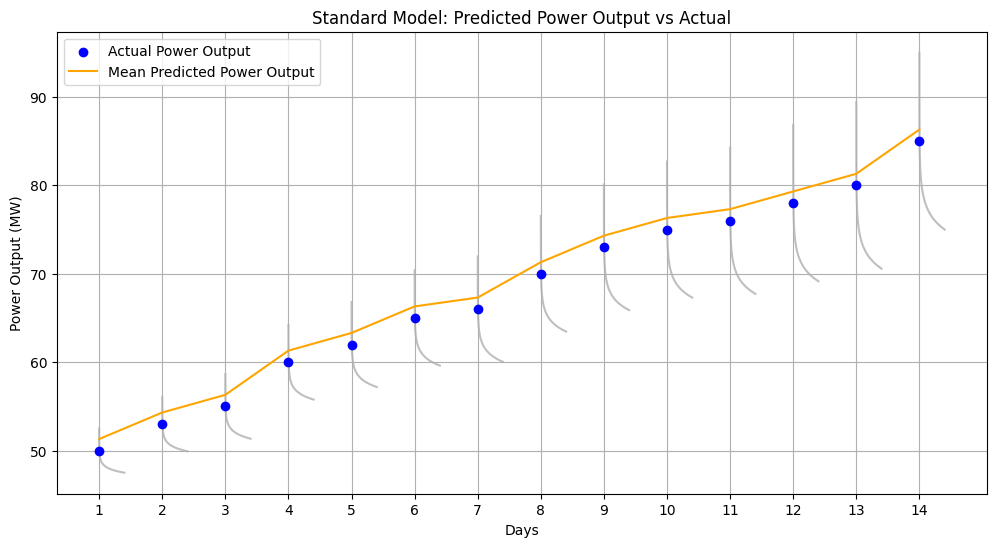

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Set parameters
days = np.arange(1, 15)  # 14 days
actual_power = np.array([50, 53, 55, 60, 62, 65, 66, 70, 73, 75, 76, 78, 80, 85])  # Example actual power values
mean_predicted_power = actual_power + 1.31  # Mean predicted power output (standard model)
sigma_values = np.linspace(0.5, 2.0, len(days))  # Varying standard deviations (scales)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot actual power output (blue)
plt.scatter(days, actual_power, label="Actual Power Output", color="blue", zorder=3)

# Plot predicted mean power output (orange)
plt.plot(days, mean_predicted_power, label="Mean Predicted Power Output", color="orange", zorder=2)

# Plot gamma distributions around actual values
for day, actual, scale in zip(days, actual_power, sigma_values):
    x_vals = np.linspace(actual - 5 * scale, actual + 5 * scale, 200)  # Range for the Gamma distribution
    x_vals = x_vals[x_vals > 0]  # Gamma distribution is defined for positive values
    y_vals = gamma.pdf(x_vals, a=2.0, scale=scale)  # Gamma distribution (shape=2, scale varies by day)
    y_vals = y_vals / y_vals.max() * 0.4  # Normalize for better visibility
    plt.plot(day + y_vals, x_vals, color="gray", alpha=0.5, zorder=1)  # Plot the distribution

# Labels, title, and legend
plt.xlabel("Days")
plt.ylabel("Power Output (MW)")
plt.title("Standard Model: Predicted Power Output vs Actual")
plt.xticks(days)
plt.legend(loc="upper left")
plt.grid(True)

# Display the plot
plt.show()


In [10]:
#pd.set_option('display.max_columns', None)  # Show all columns
#pd.set_option('display.max_rows', None)     # Show all rows

### Loading raw 50Hertz Data

In [20]:
cleaned_lines[1]

'"CTA|DE(50Hertz)","01.01.2023 00:00 - 01.01.2023 00:15 (UTC)","376","9898"\n'

In [2]:
aggregated_power = load_entsoe()
aggregated_power

,offshore,onshore
time,,
2016-01-01 00:00:00,21.0,1428.0
2016-01-01 00:15:00,27.0,1379.0
2016-01-01 00:30:00,24.0,1399.0
2016-01-01 00:45:00,20.0,1448.0
2016-01-01 01:00:00,16.0,1517.0
...,...,...
2024-12-31 22:45:00,1394.0,13237.0
2024-12-31 23:00:00,1399.0,13036.0
2024-12-31 23:15:00,1402.0,12858.0


### explorative_analysis

Summary statistics for time frame: 2016-01-01 - 2024-12-31
First 5 rows of the dataframe:


,offshore,onshore
time,,
2016-01-01 00:00:00,21.0,1428.0
2016-01-01 00:15:00,27.0,1379.0
2016-01-01 00:30:00,24.0,1399.0
2016-01-01 00:45:00,20.0,1448.0
2016-01-01 01:00:00,16.0,1517.0



Last 5 rows of the dataframe:


,offshore,onshore
time,,
2024-12-31 22:45:00,1394.0,13237.0
2024-12-31 23:00:00,1399.0,13036.0
2024-12-31 23:15:00,1402.0,12858.0
2024-12-31 23:30:00,1403.0,12907.0
2024-12-31 23:45:00,1406.0,13040.0



Summary statistics of the dataframe for time frame: 2016-01-01 - 2024-12-31


,offshore,onshore
count,315648.000000,315648.000000
mean,377.175623,3759.239843
std,354.595536,3388.417272
min,0.000000,0.000000
25%,76.000000,1113.000000
50%,277.000000,2657.000000
75%,613.000000,5463.000000
max,1480.000000,16676.000000


Expected number of entries: 315648 (2016-01-01 00:00:00 - 2024-12-31 23:45:00) 
Actual number of entries: 315648

Shape of dataframe (rows, columns) for time frame: 2016-01-01 - 2024-12-31


(315648, 2)

No duplicates found in the index.

Rows with NaN values for onshore:
In total there are: 0 NaN values for time frame 2016-01-01 00:00:00 - 2024-12-31 23:45:00


,offshore,onshore
time,,


[]

Plotting power data...
Plotting histogram for: onshore for 2016-01-01 - 2024-12-31


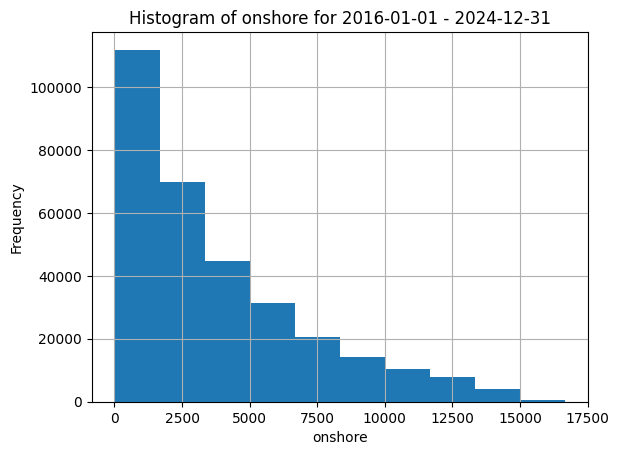


Plotting monthly time series of onshore data for the time period 2016-01-01 - 2024-12-31:


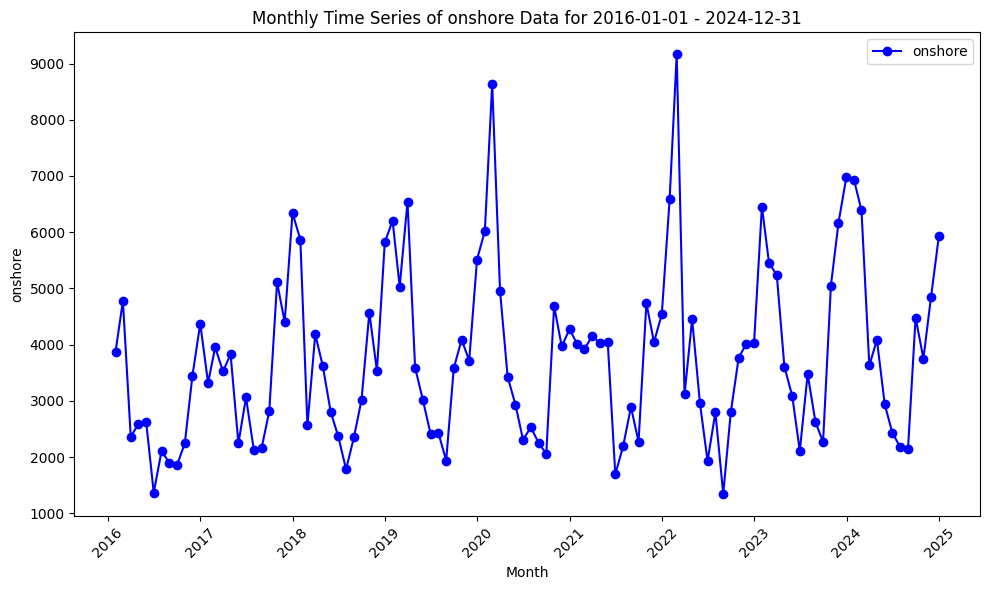

Filtered data for onshore in 07/2020: 2976 records found.


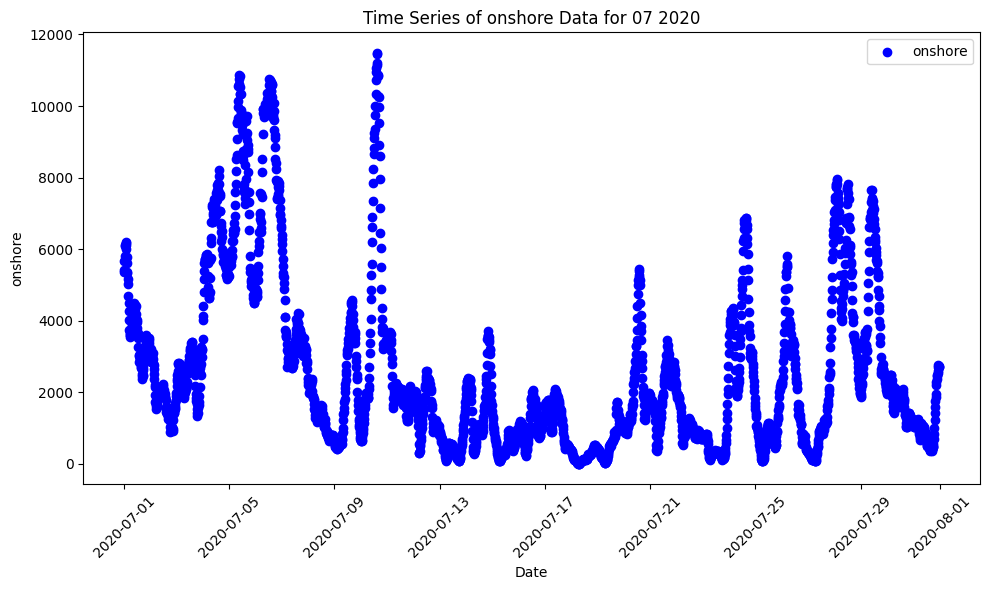

In [3]:
explorative_analysis(aggregated_power)

In [6]:
aggregated_power_proc = aggregated_power.drop(columns='offshore')
aggregated_power_proc[aggregated_power_proc.isna().any(axis=1)]

,onshore
time,
2024-10-11 16:30:00,NaN
2024-10-11 16:45:00,NaN
2024-10-11 17:00:00,NaN
2024-10-11 17:15:00,NaN
2024-10-11 17:30:00,NaN
...,...
2024-12-31 22:45:00,NaN
2024-12-31 23:00:00,NaN
2024-12-31 23:15:00,NaN


### First Analyses

#### I want to analyze for each 15 minute interval which distribution fits the data best. To this end, I turn the data frame into new one with index = day and 96 columns (24 * 4 as there are 4 15 minute intervals per hour) (both onshore and offshore i.e. 192 in total)

In [7]:
reshaped = minute_to_daily_50Hertz(aggregated_power)
reshaped

,offshore_00_00,offshore_00_15,offshore_00_30,offshore_00_45,offshore_01_00,offshore_01_15,offshore_01_30,offshore_01_45,offshore_02_00,offshore_02_15,...,onshore_21_30,onshore_21_45,onshore_22_00,onshore_22_15,onshore_22_30,onshore_22_45,onshore_23_00,onshore_23_15,onshore_23_30,onshore_23_45
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,21.0,27.0,24.0,20.0,16.0,14.0,8.0,5.0,5.0,6.0,...,316.0,350.0,359.0,385.0,425.0,432.0,467.0,503.0,509.0,528.0
2016-01-02,208.0,226.0,235.0,260.0,292.0,303.0,295.0,280.0,287.0,285.0,...,6813.0,6809.0,6785.0,6760.0,6790.0,6771.0,6700.0,6682.0,6672.0,6721.0
2016-01-03,320.0,320.0,321.0,320.0,321.0,321.0,321.0,320.0,321.0,321.0,...,5377.0,5335.0,5253.0,5296.0,5265.0,5255.0,5255.0,5239.0,5234.0,5220.0
2016-01-04,319.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,...,2284.0,2195.0,2177.0,2173.0,2165.0,2183.0,2194.0,2136.0,2100.0,2050.0
2016-01-05,320.0,319.0,319.0,320.0,319.0,319.0,319.0,320.0,319.0,319.0,...,1475.0,1441.0,1391.0,1414.0,1420.0,1397.0,1353.0,1341.0,1218.0,1121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Analyse the daily time series for each 15-minute interval separately by fitting a Weibull distribution to the time series data for each 15-minute. To be more flexible fit a Weibull distribution rather than a Gaussian distribution. The most important parameter is the "shape" parameter. For "shape" <= 1 the maximum of the distribution is at zero; for "shape" > 1 the maximum is above zero. The scale parameter simply says how large the variable can be

Why weibull? its a flexible distribution because the shape parameter allows for distributions that peak at zero and distributions that ressemble the normal distribution


Plotting the values for the other parameter (scale) which is only relevant for normalization

In [8]:
# Calculate Weibull MLEs
mles = get_weibull_mles(reshaped)
mles

,time_interval,shape,scale,th_mean,mean,error
0,offshore_00_00,0.943828,368.103687,377.909538,378.276271,-0.000969
1,offshore_00_15,0.934357,365.128671,376.727236,377.044902,-0.000843
2,offshore_00_30,0.930655,362.551055,374.814331,375.080761,-0.000710
3,offshore_00_45,0.930445,360.975112,373.227560,373.559089,-0.000887
4,offshore_01_00,0.923041,357.583080,371.229777,371.502339,-0.000734
...,...,...,...,...,...,...
187,onshore_22_45,1.252746,4328.702775,4029.673580,4024.471304,0.001293
188,onshore_23_00,1.249402,4310.649440,4015.307062,4010.149095,0.001286
189,onshore_23_15,1.245312,4292.834732,4001.722830,3996.628197,0.001275
190,onshore_23_30,1.241225,4274.951816,3988.090456,3983.315346,0.001199


### Taking only onshore into consideration

In [9]:
onshore_mles = mles[mles['time_interval'].str.startswith('onshore')]

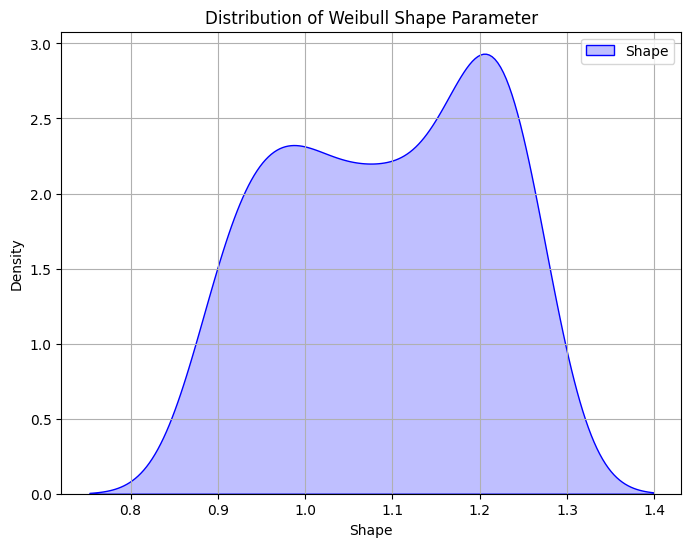

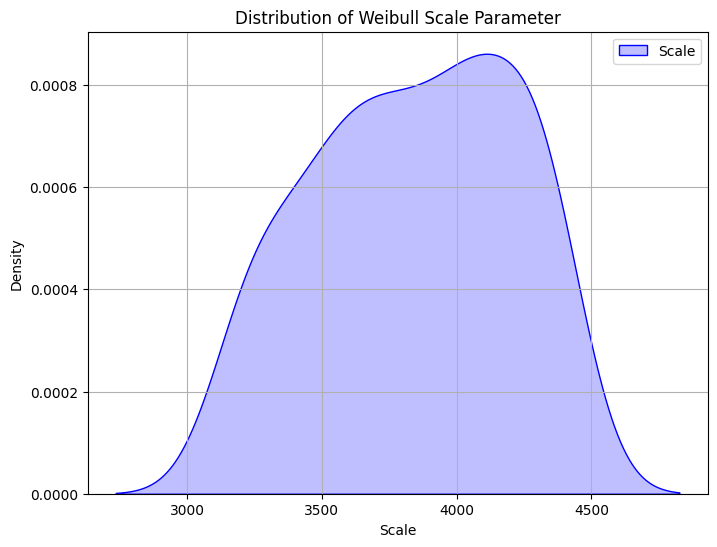

In [10]:
# Calculate Weibull MLEs
mles = get_weibull_mles(reshaped)

# Plot the distribution of Weibull parameters
#plot_weibull_parameters_distribution(mles, parameter="shape")
#plot_weibull_parameters_distribution(mles, parameter="scale")

plot_weibull_parameters_distribution(onshore_mles, parameter="shape")
plot_weibull_parameters_distribution(onshore_mles, parameter="scale")




In [11]:
#weibull_parameters_onshore[weibull_parameters_onshore['shape'] <= 0.9]

Inspect the result of the fit for each 15 minute interval (onshore)
The mean of the data is pretty close to the theoretical mean

c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:2581: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


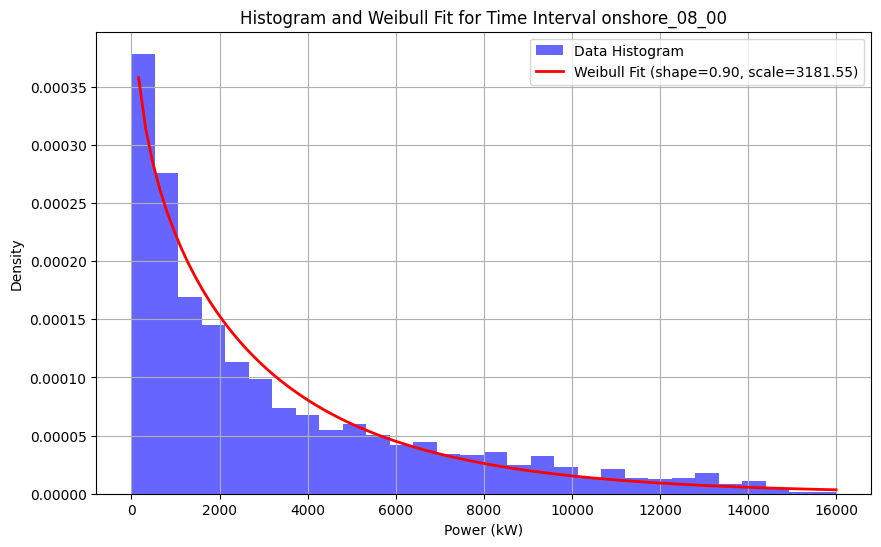

In [12]:
# Plot Weibull fit for a specific interval
plot_weibull_for_one_interval(reshaped, "onshore_08_00")

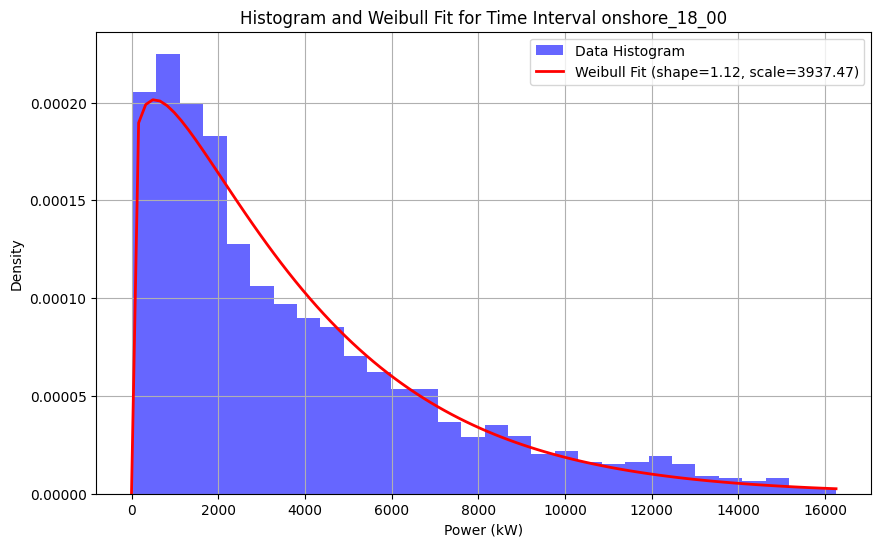

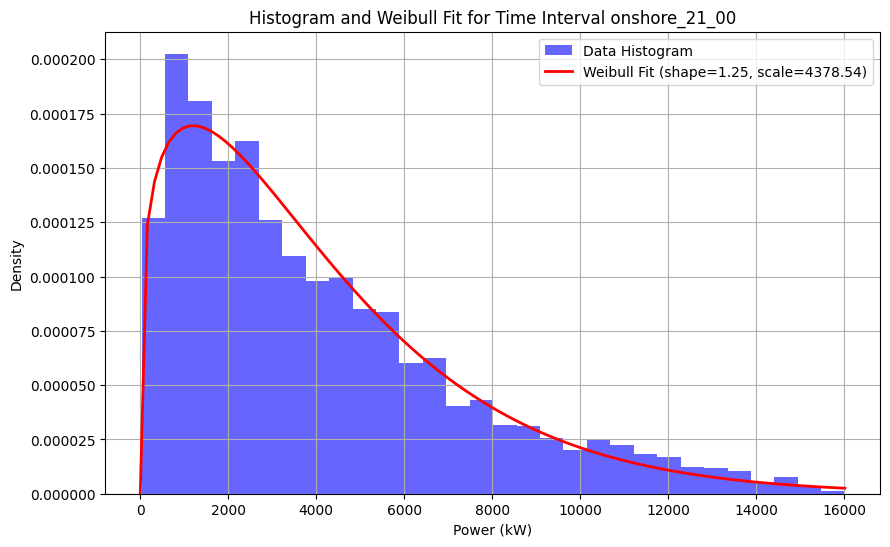

In [13]:
plot_weibull_for_one_interval(reshaped, "onshore_18_00")
plot_weibull_for_one_interval(reshaped, "onshore_21_00")

Plot the frequency distribution of the data and the weibull for a selected 15 minute time interval.

Interpretation:
- At 08:00 the most likely power is very small (Weibull would predict zero)
- At 18:00, 21:00 the most likely power is around 700-1000 kW

Implication for forecasting model:
- Has to take into account that different time intervals result in different distribution shapes


#### Analysis of the distribution of the daily delta Powers

- See below for a possible explanation as to why the mean is equal to 1

In [14]:
reshaped2 = add_previous_day_and_calculate_differences(aggregated_power)

1.0009357454772303


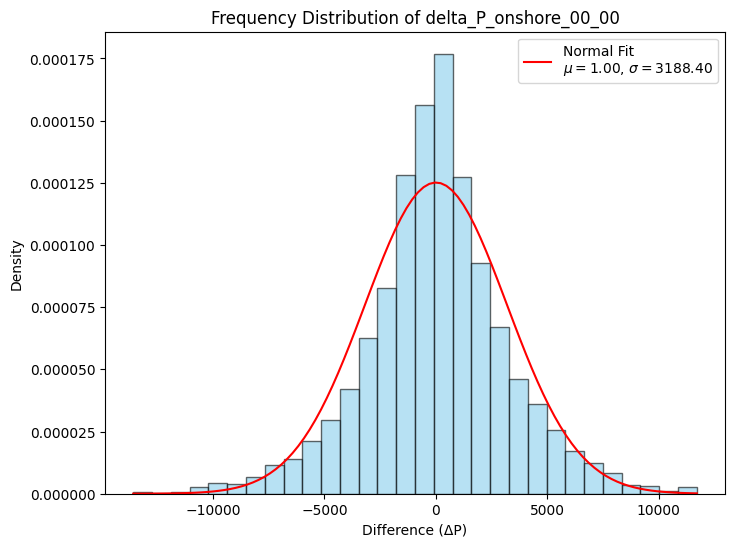

1.0087336244541485


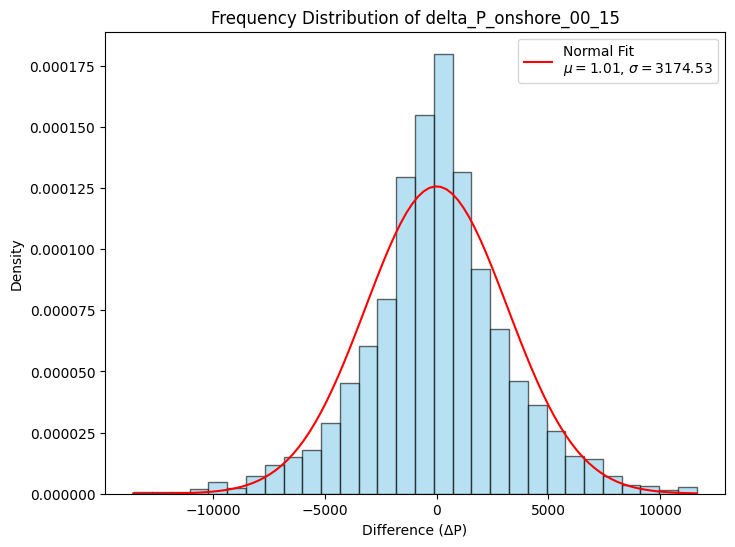

0.9887710542732376


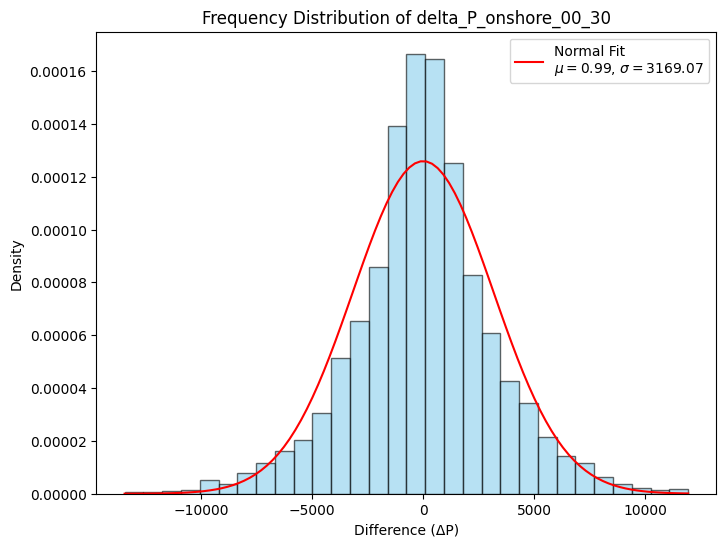

0.9457267623206488


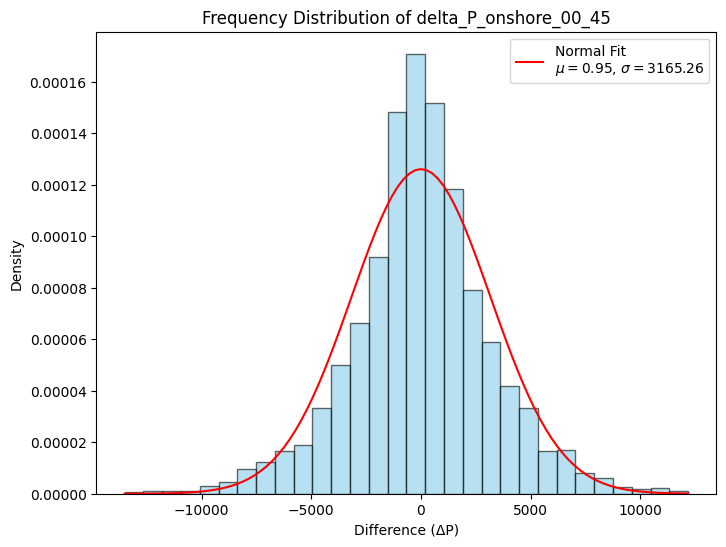

0.9026824703680599


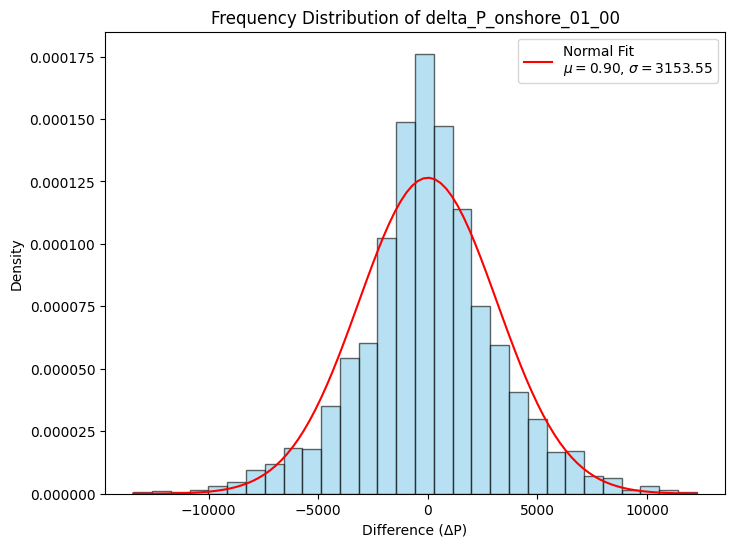

0.8880224578914535


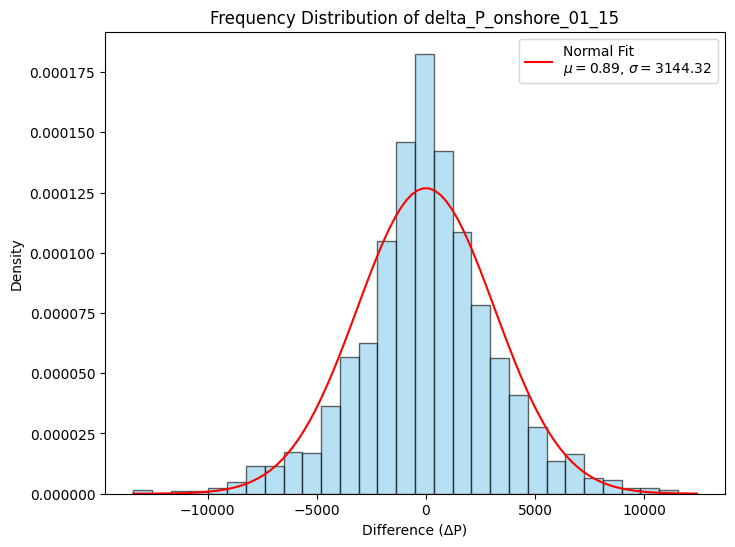

0.872426699937617


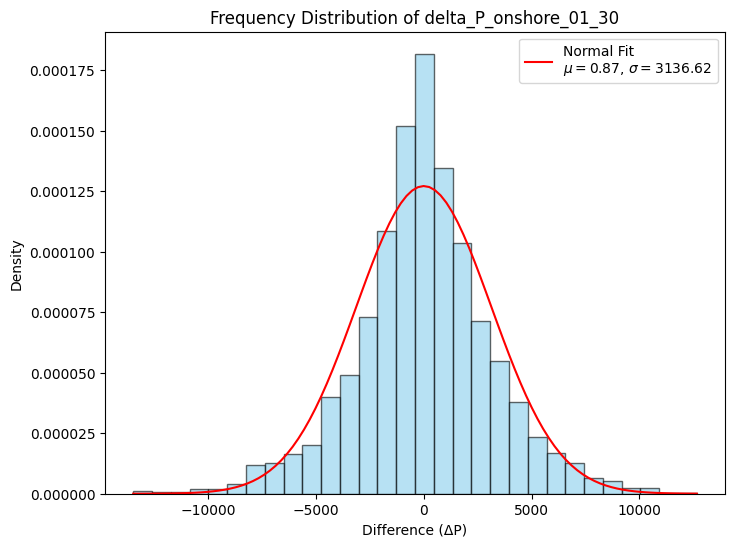

0.8583905177791641


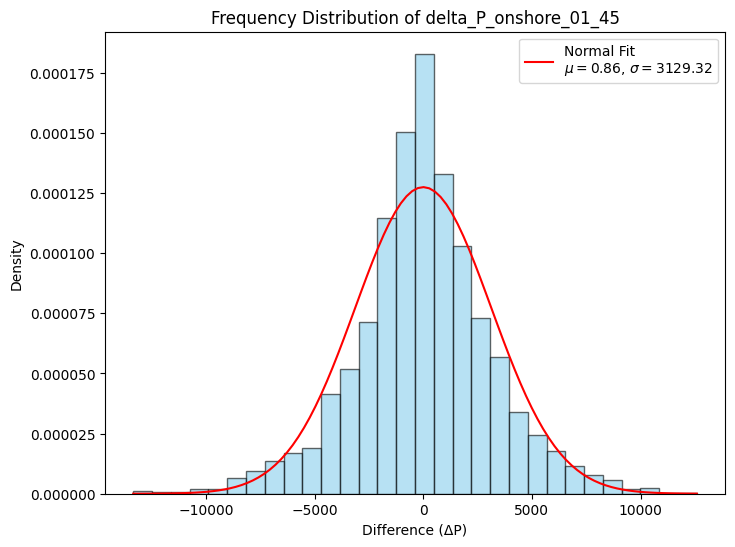

0.835308796007486


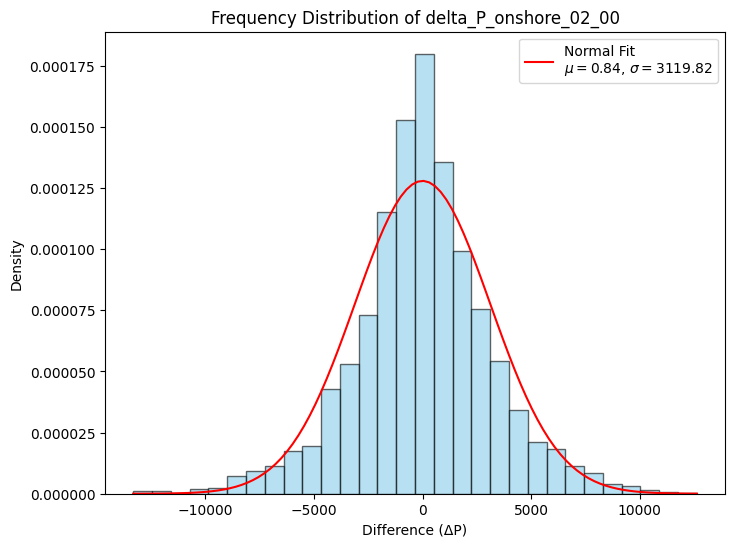

0.8452900810979413


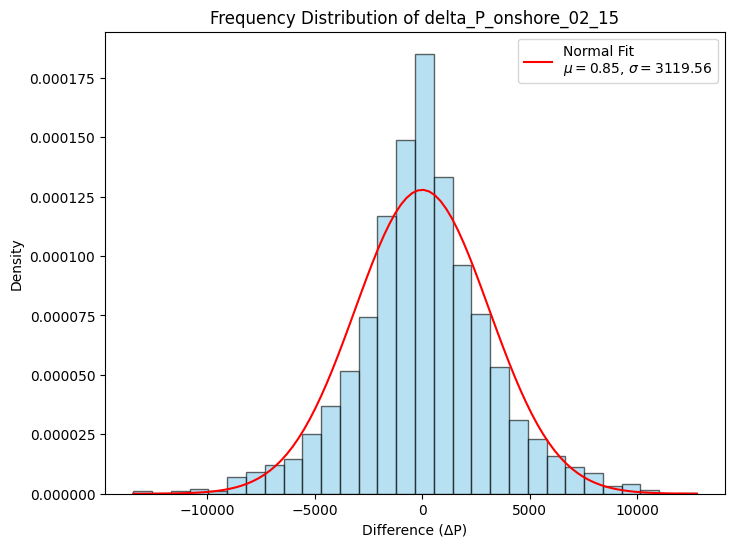

Overall Mean of all column means: 1.1248137795131268


In [15]:
plot_difference_histograms(reshaped2)

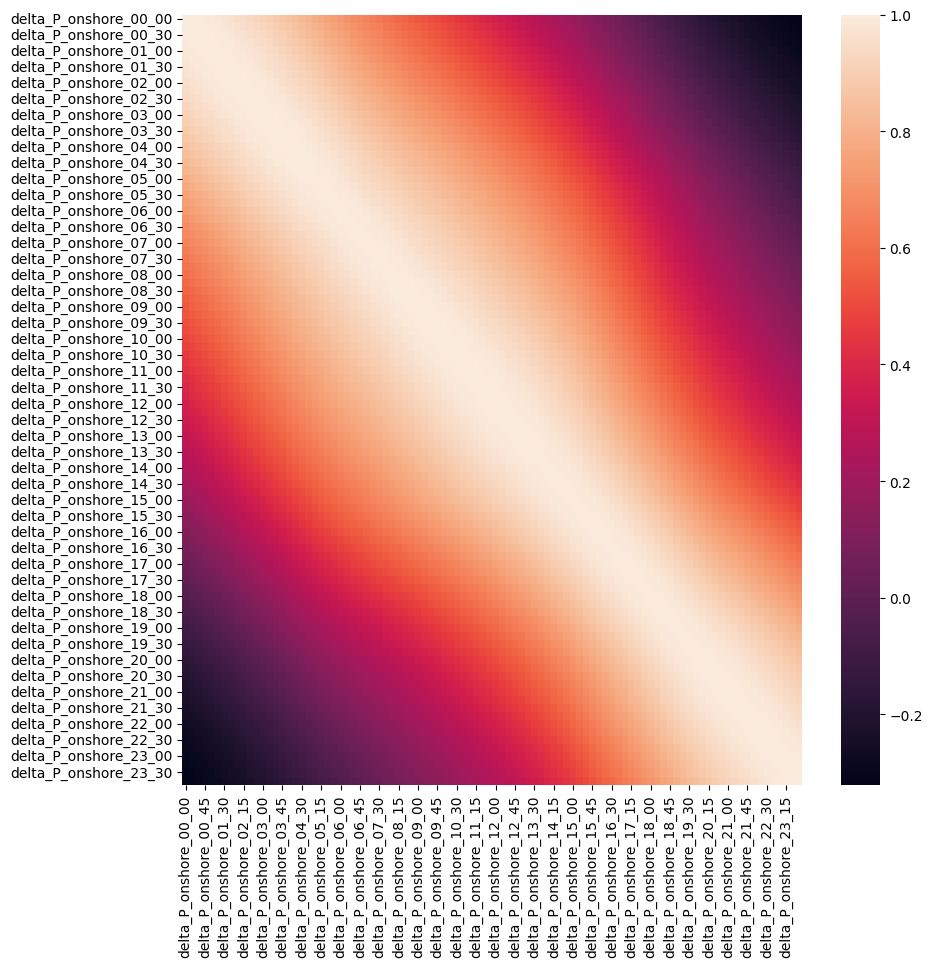

In [16]:
fig, ax = plt.subplots(figsize=(10,10))

delta_columns = [col for col in reshaped2.columns if 'delta_P_' in col]
delta_data = reshaped2[delta_columns].dropna()  # Drop rows with NaN values
mean = np.mean(delta_data, axis=0)
corr = delta_data.corr()  # Computes the correlation matrix between columns

sns.heatmap(corr, ax=ax)
plt.show()

### Time Series of mean per month

In [17]:
plot_power_data_for_specific_month(aggregated_power) ## January 2024

ValueError: invalid literal for int() with base 10: ''

### First attempt to include installed capacity. Since data is updated yearly only, I need to interpolate. This is an approximation since in reality more capacity is not added continuously 

In [18]:
inst_cap = load_installed_capacity()
inst_cap

,installed_capacity (MW)
2017-01-01 00:00:00,17866.0
2017-01-01 00:15:00,17866.0
2017-01-01 00:30:00,17866.0
2017-01-01 00:45:00,17866.0
2017-01-01 01:00:00,17866.0
...,...
2023-12-31 22:45:00,21078.0
2023-12-31 23:00:00,21078.0
2023-12-31 23:15:00,21078.0
2023-12-31 23:30:00,21078.0


<Axes: >

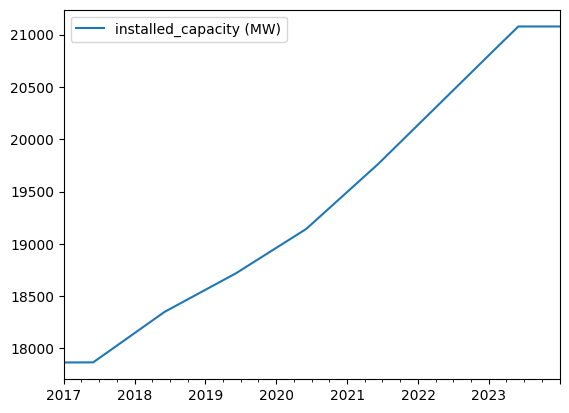

In [19]:
inst_cap.plot()

In [20]:
aggregated_power_inst_cap = pd.concat([aggregated_power, load_installed_capacity()])
aggregated_power_inst_cap

,offshore,onshore,installed_capacity (MW)
2016-01-01 00:00:00,21.0,1428.0,NaN
2016-01-01 00:15:00,27.0,1379.0,NaN
2016-01-01 00:30:00,24.0,1399.0,NaN
2016-01-01 00:45:00,20.0,1448.0,NaN
2016-01-01 01:00:00,16.0,1517.0,NaN
...,...,...,...
2023-12-31 22:45:00,NaN,NaN,21078.0
2023-12-31 23:00:00,NaN,NaN,21078.0
2023-12-31 23:15:00,NaN,NaN,21078.0
2023-12-31 23:30:00,NaN,NaN,21078.0


The red line shows the maximum power output achieved and green the installed capacity. The increase is more or less parallel, showing that it makes sense to consider a normalized power output.

AttributeError: 'DataFrame' object has no attribute 'installed_capacity'

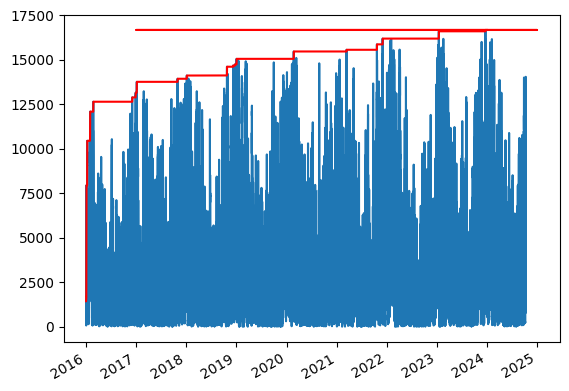

In [21]:
aggregated_power_inst_cap.onshore.plot()
aggregated_power_inst_cap.onshore.expanding().max().plot(color="red")
aggregated_power_inst_cap.installed_capacity.plot(color="green")
plt.axhline(y=12600, color='b', linestyle='--', label='Threshold (20000)')

print(aggregated_power_inst_cap.onshore.expanding().max())


### Explanation as to why the mean of the delta power distributions is 1 and not zero

Calculating the average daily increase in power produced using the max gives an increase of about 1.3 MW per day. This compares well with what we get from the average daily increase calculated from installed capacity. This explains why the mean of the delta power distribution P_t - P_t-1 is about 1

In [ ]:
(16676.0-12600)/8.5 / 365

1.3137792103142627

In [ ]:
(21078 - 17866)/7 / 365

1.2571428571428571

In [ ]:
#[(x, df.resample('M').mean().onshore.autocorr(lag=x).item()) for x in range(1,13)]

In [ ]:
#pd.plotting.autocorrelation_plot(df.resample('M').mean().offshore)

In [ ]:
# Plot the data
#df.plot(title="Time Series Data")
#df2 = df.resample('D').mean()
#column = "onshore"
# 1. Autocorrelation and Partial Autocorrelation to detect periodicity
#lag_acf = acf(df2[column], nlags=40)
#lag_pacf = pacf(df2[column], nlags=40)
#display(lag_acf)
#display(lag_pacf)

In [22]:
# 2. Fit an ARMA model to the data (ARMA(p,q) model)
model = ARIMA(df[column], order=(2, 0, 2))  # ARMA is a special case of ARIMA(p, 0, q)
arma_model = model.fit()

# Print the summary of the fitted model
print(arma_model.summary())

# 3. Analyze the residuals to check for periodicity in the residuals
residuals = arma_model.resid

plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of ARMA Model')
plt.show()

NameError: name 'df' is not defined

In [ ]:
# 4. Optionally, use FFT to find periodicity
fft_vals = np.fft.fft(df[column])
fft_freq = np.fft.fftfreq(len(fft_vals))

plt.figure(figsize=(10, 4))
plt.plot(fft_freq, np.abs(fft_vals))
plt.title('Frequency Spectrum')
plt.show()

In [ ]:
lag_acf

In [ ]:
lag_pacf

In [ ]:
df.onshore.hist(bins=30)

In [ ]:
df.offshore.hist(bins=30)

In [ ]:
sns.kdeplot(df.onshore)

In [ ]:
sns.kdeplot(df.offshore)

In [ ]:
df.Area.unique()

### Analysis with processed data

In [ ]:
aggregated_power_proc = aggregated_power.drop(columns='offshore')

,onshore
time,
2016-01-01 00:00:00,1428.0
2016-01-01 00:15:00,1379.0
2016-01-01 00:30:00,1399.0
2016-01-01 00:45:00,1448.0
2016-01-01 01:00:00,1517.0
...,...
2024-12-31 22:45:00,NaN
2024-12-31 23:00:00,NaN
2024-12-31 23:15:00,NaN


### Check whether power in onshore makes sense compared to the installed capacity

between 2016-2024 the max onshore power value is 16676.000000 MW, the min onshore power is 0 MW

The installed capacity plot shows that the min installed capacity was 17866.0 MW



In [ ]:
inst_cap.min()

installed_capacity    17866.0
dtype: float64

### Check that there are no missing values
Explorative analysis shows that:
- Expected number of entries: 315648 (2016-01-01 00:00:00 - 2024-12-31 23:45:00) 
- Actual number of entries: 315648

### Split into Train, Test dataset

- 2023 is the validation dataset
- 2024 is the test dataset: at this point (24.11.2024 still incomplete. Will download at the start of 2025)
- 2016-2022 Training dataset

In [23]:
# Set the split dates
train_end_date = "2022-12-31 23:45:00"       # End date for the training set
validation_end_date = "2023-12-31 23:45:00"  # End date for the validation set

# Call the function with the DataFrame `df`
train_data, validation_data, test_data = to_train_validation_test_data(
    df=aggregated_power_proc,
    train_end_date=train_end_date,
    validation_end_date=validation_end_date
)

# of training observations: 245472 | 77.77%
# of validation observations: 35040 | 11.10%
# of test observations: 35136 | 11.13%


In [ ]:
train_data

,onshore
time,
2016-01-01 00:00:00,1428.0
2016-01-01 00:15:00,1379.0
2016-01-01 00:30:00,1399.0
2016-01-01 00:45:00,1448.0
2016-01-01 01:00:00,1517.0
...,...
2022-12-31 22:45:00,10379.0
2022-12-31 23:00:00,9791.0
2022-12-31 23:15:00,9810.0


In [ ]:
validation_data

,onshore
time,
2023-01-01 00:00:00,9898.0
2023-01-01 00:15:00,10104.0
2023-01-01 00:30:00,9738.0
2023-01-01 00:45:00,10196.0
2023-01-01 01:00:00,9768.0
...,...
2023-12-31 22:45:00,7960.0
2023-12-31 23:00:00,8086.0
2023-12-31 23:15:00,7968.0


In [ ]:
test_data

,onshore
time,
2024-01-01 00:00:00,8151.0
2024-01-01 00:15:00,8302.0
2024-01-01 00:30:00,8081.0
2024-01-01 00:45:00,8187.0
2024-01-01 01:00:00,8072.0
...,...
2024-12-31 22:45:00,NaN
2024-12-31 23:00:00,NaN
2024-12-31 23:15:00,NaN


In [24]:
train_transf = minute_to_daily_50Hertz(train_data)
train_transf.head()

,onshore_00_00,onshore_00_15,onshore_00_30,onshore_00_45,onshore_01_00,onshore_01_15,onshore_01_30,onshore_01_45,onshore_02_00,onshore_02_15,...,onshore_21_30,onshore_21_45,onshore_22_00,onshore_22_15,onshore_22_30,onshore_22_45,onshore_23_00,onshore_23_15,onshore_23_30,onshore_23_45
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1428.0,1379.0,1399.0,1448.0,1517.0,1511.0,1539.0,1575.0,1628.0,1685.0,...,316.0,350.0,359.0,385.0,425.0,432.0,467.0,503.0,509.0,528.0
2016-01-02,595.0,650.0,696.0,735.0,738.0,774.0,853.0,939.0,985.0,1030.0,...,6813.0,6809.0,6785.0,6760.0,6790.0,6771.0,6700.0,6682.0,6672.0,6721.0
2016-01-03,6600.0,6634.0,6645.0,6644.0,6646.0,6764.0,6858.0,6846.0,6846.0,6847.0,...,5377.0,5335.0,5253.0,5296.0,5265.0,5255.0,5255.0,5239.0,5234.0,5220.0
2016-01-04,5069.0,4983.0,4867.0,4754.0,4739.0,4644.0,4676.0,4629.0,4584.0,4394.0,...,2284.0,2195.0,2177.0,2173.0,2165.0,2183.0,2194.0,2136.0,2100.0,2050.0
2016-01-05,2081.0,2115.0,2108.0,2082.0,2083.0,2045.0,2050.0,2116.0,2089.0,2010.0,...,1475.0,1441.0,1391.0,1414.0,1420.0,1397.0,1353.0,1341.0,1218.0,1121.0


In [25]:
val_transf = minute_to_daily_50Hertz(validation_data)
val_transf

,onshore_00_00,onshore_00_15,onshore_00_30,onshore_00_45,onshore_01_00,onshore_01_15,onshore_01_30,onshore_01_45,onshore_02_00,onshore_02_15,...,onshore_21_30,onshore_21_45,onshore_22_00,onshore_22_15,onshore_22_30,onshore_22_45,onshore_23_00,onshore_23_15,onshore_23_30,onshore_23_45
date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,9898.0,10104.0,9738.0,10196.0,9768.0,10258.0,10073.0,10285.0,9368.0,8769.0,...,4380.0,4365.0,4341.0,4401.0,4455.0,4503.0,4735.0,4865.0,4911.0,5009.0
2023-01-02,5146.0,5385.0,5411.0,5444.0,6019.0,6407.0,6554.0,6829.0,7190.0,7594.0,...,6773.0,6906.0,6979.0,7146.0,7211.0,7261.0,7225.0,7435.0,7682.0,7531.0
2023-01-03,7413.0,7362.0,7164.0,7226.0,7126.0,6851.0,6659.0,6530.0,6387.0,6316.0,...,6258.0,6365.0,6562.0,6731.0,6796.0,6982.0,6889.0,7024.0,7172.0,7183.0
2023-01-04,7421.0,7723.0,7918.0,8015.0,7931.0,8083.0,8143.0,8233.0,8001.0,8010.0,...,14220.0,14133.0,13917.0,13665.0,13540.0,13863.0,13882.0,13208.0,12611.0,12367.0
2023-01-05,12678.0,13029.0,12980.0,12896.0,12478.0,12502.0,12875.0,12976.0,12810.0,12814.0,...,1452.0,1347.0,1256.0,1117.0,1074.0,1036.0,1113.0,1129.0,1145.0,1219.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,9581.0,9409.0,9063.0,8826.0,8618.0,8470.0,8388.0,8331.0,8251.0,8006.0,...,9877.0,10105.0,10353.0,10258.0,10305.0,10367.0,10574.0,10606.0,10841.0,11070.0
2023-12-28,11063.0,10673.0,10423.0,10536.0,10770.0,10718.0,10749.0,10748.0,10812.0,11129.0,...,13082.0,13092.0,13183.0,13374.0,13402.0,13305.0,13023.0,12374.0,12166.0,12017.0
2023-12-29,11821.0,11741.0,11638.0,11628.0,11617.0,11356.0,11484.0,11571.0,11658.0,11607.0,...,11213.0,11256.0,11598.0,11997.0,12021.0,12213.0,12306.0,12041.0,11928.0,11864.0


In [26]:
test_transf = minute_to_daily_50Hertz(test_data)
test_transf

,onshore_00_00,onshore_00_15,onshore_00_30,onshore_00_45,onshore_01_00,onshore_01_15,onshore_01_30,onshore_01_45,onshore_02_00,onshore_02_15,...,onshore_21_30,onshore_21_45,onshore_22_00,onshore_22_15,onshore_22_30,onshore_22_45,onshore_23_00,onshore_23_15,onshore_23_30,onshore_23_45
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,8151.0,8302.0,8081.0,8187.0,8072.0,8125.0,8363.0,8413.0,8301.0,8138.0,...,7175.0,6946.0,6786.0,6531.0,6433.0,6194.0,6026.0,5871.0,5731.0,5519.0
2024-01-02,5301.0,5122.0,4886.0,4702.0,4676.0,4470.0,4355.0,4254.0,4216.0,4265.0,...,9575.0,9668.0,9955.0,10179.0,10237.0,10221.0,10152.0,10102.0,10181.0,10245.0
2024-01-03,10327.0,10424.0,10421.0,10464.0,10638.0,10804.0,10890.0,10940.0,10857.0,10746.0,...,9473.0,9425.0,9417.0,9407.0,9468.0,9530.0,9502.0,9349.0,9250.0,9143.0
2024-01-04,9127.0,9115.0,9197.0,9212.0,9162.0,9348.0,9393.0,9276.0,9318.0,9390.0,...,648.0,629.0,603.0,558.0,526.0,524.0,553.0,571.0,590.0,609.0
2024-01-05,644.0,674.0,737.0,800.0,827.0,874.0,936.0,956.0,1003.0,1062.0,...,4076.0,4065.0,3957.0,3867.0,3810.0,3733.0,3629.0,3576.0,3499.0,3447.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Baseline model:

1. MSE with Default Bias:
- Predicts each $P_t^{\hat{}}$ as $P_{t-1}$ + Gaussian error term.
- Calculates MSE for both training and validation data.

2. MSE with Trend-Based Bias:
- Predicts $P_t^{\hat{}}$ as $P_{t-1} + \text{trend}$, where trend is estimated from the training data.
- Calculates MSE again for both datasets.

result: sigma is nearly as large as mu

The ARIMA model shows that the assumption of normal error term is not fulfilled. Therefore apply the model to log of the power.
This avoids negative terms.
Note that this implies $P_t = C * P_{t-1}$ where C is exp(0,0007), slightly larger than 1

The increase due to installation of capacity does not show up as an additive term (say 1MW per day) but as a factor


In [27]:
def model(p_t, bias=1):
    p_tpp = p_t.shift(1) + bias # Pt^ = Pt−1 + bias (1 because the average increse in capacity is 1MW)
    return p_tpp

col = 'onshore_01_30'
p_t_train = train_transf[col]
p_t_val = val_transf[col]

print("Model: trend=1")

res_train = pd.DataFrame({"p": p_t_train, "p_hat": model(p_t_train)})
mse = res_train.apply(lambda s: (s.p - s.p_hat)**2, axis=1).mean().item()
print("Train: MSE =", res_train.apply(lambda s: (s.p - s.p_hat)**2, axis=1).mean().item())
print(mse)

res_val = pd.DataFrame({"p": p_t_val, "p_hat": model(p_t_val)})
print("Val: MSE =", res_val.apply(lambda s: (s.p - s.p_hat)**2, axis=1).mean().item())

print(80*"-")

trend = (p_t_train - p_t_train.shift(1)).mean().item() # Computes the average trend (Δ𝑃𝑡) in the training set: trend=mean(Pt −Pt−1).
print(f"Model: trend={trend} (Δpt.mean())")
res_train = pd.DataFrame({"p": p_t_train, "p_hat": model(p_t_train, bias=trend)})
print("Train: MSE =", res_train.apply(lambda s: (s.p - s.p_hat)**2, axis=1).mean().item())

res_val = pd.DataFrame({"p": p_t_val, "p_hat": model(p_t_val, bias=trend)})
print("Val: MSE =", res_val.apply(lambda s: (s.p - s.p_hat)**2, axis=1).mean().item())

Model: trend=1
Train: MSE = 9147722.766431924
9147722.766431924
Val: MSE = 12415262.887362637
--------------------------------------------------------------------------------
Model: trend=2.9151017214397497 (Δpt.mean())
Train: MSE = 9147719.09881732
Val: MSE = 12415330.710884908


In [28]:
def model(p_t, bias=np.log(1)):
    p_tpp = p_t.shift(1) + bias # Pt^ = Pt−1 + bias (1 because the average increse in capacity is 1MW)
    return p_tpp

col = 'onshore_09_30'
p_t_train = np.log(train_transf[col])
p_t_val = np.log(val_transf[col])

print("Model: trend=1")

res_train = pd.DataFrame({"p": p_t_train, "p_hat": model(p_t_train)})
mse = res_train.apply(lambda s: (s.p - s.p_hat)**2, axis=1).mean().item()
print("Train: MSE =", res_train.apply(lambda s: (s.p - s.p_hat)**2, axis=1).mean().item())
print(mse)

res_val = pd.DataFrame({"p": p_t_val, "p_hat": model(p_t_val)})
print("Val: MSE =", res_val.apply(lambda s: (s.p - s.p_hat)**2, axis=1).mean().item())

print(80*"-")

trend = (p_t_train - p_t_train.shift(1)).mean().item() # Computes the average trend (Δ𝑃𝑡) in the training set: trend=mean(Pt −Pt−1).
print(f"Model: trend={trend} (Δpt.mean())")
res_train = pd.DataFrame({"p": p_t_train, "p_hat": model(p_t_train, bias=trend)})
print("Train: MSE =", res_train.apply(lambda s: (s.p - s.p_hat)**2, axis=1).mean().item())

res_val = pd.DataFrame({"p": p_t_val, "p_hat": model(p_t_val, bias=trend)})
print("Val: MSE =", res_val.apply(lambda s: (s.p - s.p_hat)**2, axis=1).mean().item())

Model: trend=1
Train: MSE = 2.0395844211382173
2.0395844211382173
Val: MSE = 2.1664859157144374
--------------------------------------------------------------------------------
Model: trend=0.0009019640794340878 (Δpt.mean())
Train: MSE = 2.039583607599017
Val: MSE = 2.166486738539221


In [31]:
res_val

,p,p_hat
date,,
2023-01-01,8.919854,NaN
2023-01-02,9.179469,8.920756
2023-01-03,7.959975,9.180371
2023-01-04,9.590488,7.960876
2023-01-05,9.552155,9.591390
...,...,...
2023-12-27,7.328437,9.464643
2023-12-28,9.365119,7.329339
2023-12-29,9.531046,9.366021


In [ ]:
model()

In [ ]:
res_train.mean()

p        7.815014
p_hat    7.815201
dtype: float64

In [ ]:
np.sqrt(mse)

np.float64(1.1147014552400645)

In [ ]:
np.sqrt(mse)/res_train.mean()

p        0.142636
p_hat    0.142632
dtype: float64

In [29]:
from statsmodels.tsa.arima.model import ARIMA


model = ARIMA(np.log(train_transf[col]), order=(0,1,0), trend="t")
res = model.fit()
print(res.summary())
print(res.params)

c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:          onshore_09_30   No. Observations:                 2557
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4537.696
Date:                Thu, 19 Dec 2024   AIC                           9079.392
Time:                        18:37:24   BIC                           9091.084
Sample:                    01-01-2016   HQIC                          9083.632
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0009      0.028      0.032      0.975      -0.055       0.056
sigma2         2.0396      0.043     47.406      0.000       1.955       2.124
Ljung-Box (L1) (Q):                 297.03   Jarque-

In [ ]:
#res.forecast("2023-01-01", "2023-12-31")

2023-01-01    7.350989
Freq: D, dtype: float64

In [ ]:
np.log(val_transf[col])

date
2023-01-01    9.217614
2023-01-02    8.787831
2023-01-03    8.803725
2023-01-04    9.004914
2023-01-05    9.463043
                ...   
2023-12-27    9.034557
2023-12-28    9.282568
2023-12-29    9.348710
2023-12-30    9.355047
2023-12-31    8.375630
Name: onshore_01_30, Length: 365, dtype: float64

### Plotting a frequency plot of log power

In [ ]:
aggregated_power_proc['onshore'][aggregated_power_proc['onshore'] == 0]


time
2016-06-05 06:45:00    0.0
2016-06-05 07:00:00    0.0
2019-01-20 11:00:00    0.0
2019-02-15 13:00:00    0.0
2019-03-24 10:15:00    0.0
2021-08-21 07:30:00    0.0
2021-08-21 07:45:00    0.0
2022-08-26 07:00:00    0.0
Name: onshore, dtype: float64

In [ ]:
positive_onshore = aggregated_power_proc['onshore'][aggregated_power_proc['onshore'] > 0]
positive_onshore.isna().sum()

np.int64(0)

(array([ 3.,  4., 12., 11., 15., 42., 63., 87., 76., 52.]),
 array([4.11087386, 4.66351055, 5.21614724, 5.76878393, 6.32142062,
        6.87405731, 7.426694  , 7.97933069, 8.53196738, 9.08460407,
        9.63724076]),
 <BarContainer object of 10 artists>)

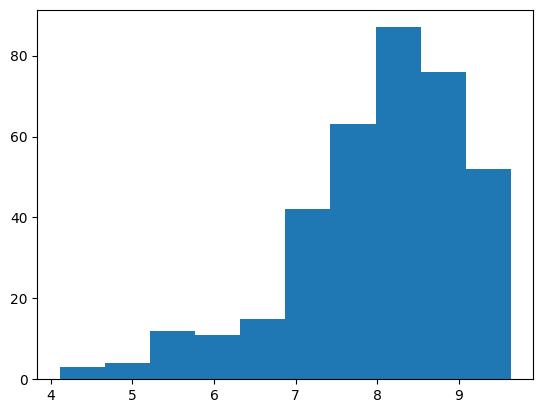

In [ ]:
plt.hist(p_t_val, bins=10)

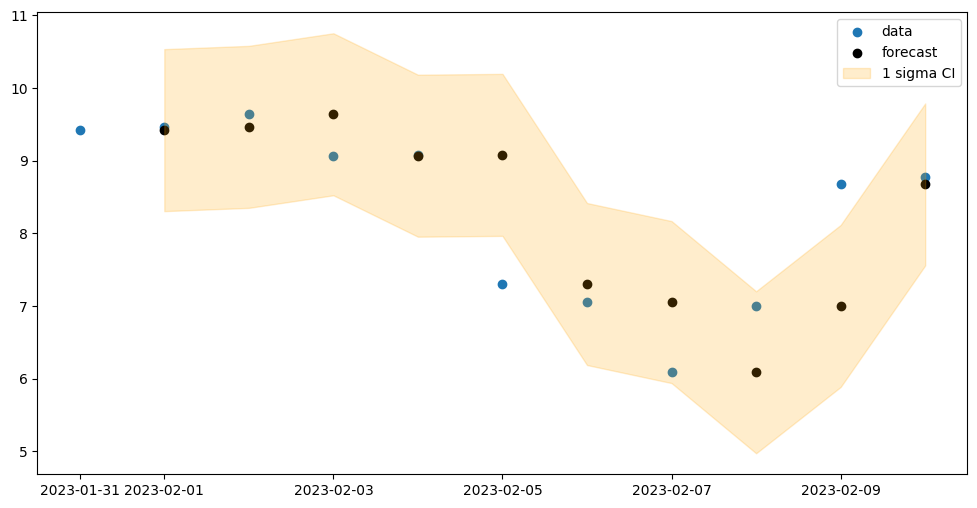

In [ ]:
subset = p_t_val['2023-01-31':'2023-02-10']
train_std = np.sqrt(mse)

plt.figure(figsize=(12, 6))  # Set the figure size (width=12 inches, height=6 inches)

plt.scatter(subset.index, subset, label='data')
plt.scatter(subset.index, subset.shift(1), c='black', label='forecast')

#plt.fill_between(subset.index, subset.shift(1) - train_std, subset.shift(1) + train_std, color='orange', alpha=0.2, label='1 sigma CI')
plt.legend()




In [ ]:
from scipy.stats import gamma

In [ ]:
qs = np.arange(0.1, 1, 0.1)
a = 2
scale = 0
x = gamma.ppf(qs, a, scale=scale)
x

plt.scatter()

c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2286: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

In [ ]:
qs = np.arange(0.1, 1, 0.1)
a = 4
scale = 0
x_qs = gamma.ppf(qs, a1, scale=scale1)
x_qs

array([1.81082269, 2.14282552, 2.40664372, 2.64886862, 2.88965039,
       3.14465069, 3.43355902, 3.79325764, 4.33157051])

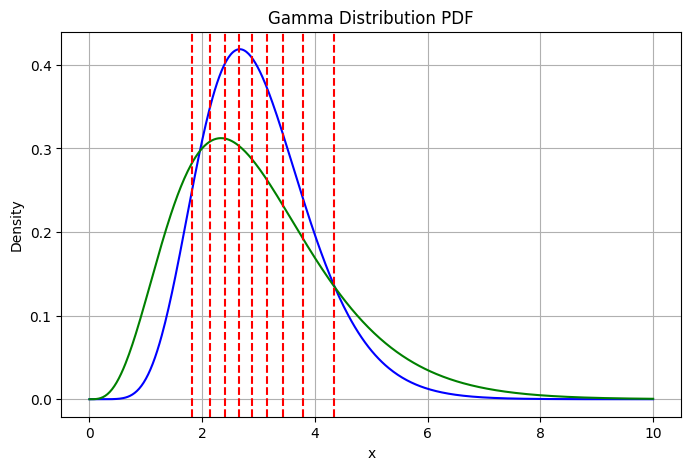

In [ ]:
# Parameters
mu1 = 3
sigma1_sq = 1
mu2 = 3
sigma2_sq = 2

a1 = mu1 * mu1 / sigma1_sq  # Shape parameter
a2 = mu2 * mu2 / sigma2_sq  # Shape parameter
scale1 = sigma1_sq / mu1  # Scale parameter
scale2 = sigma2_sq / mu2  # Scale parameter

x = np.linspace(0, 10, 500)  # Range of x values for the PDF

# Compute the PDFs
pdf_values = gamma.pdf(x, a1, scale=scale1)
pdf_values1 = gamma.pdf(x, a2, scale=scale2)

# Plot the PDFs
plt.figure(figsize=(8, 5))
plt.plot(x, pdf_values, label=f'Gamma PDF (a={a1}, scale={scale1})', color='blue')
plt.plot(x, pdf_values1, label=f'Gamma PDF (a={a2}, scale={scale2})', color='green')

for v in x_qs:
    plt.axvline(x=v, color='red', linestyle='--', label=f'x={v}')

plt.title("Gamma Distribution PDF")
plt.xlabel("x")
plt.ylabel("Density")
#plt.legend()
plt.grid()
plt.show()


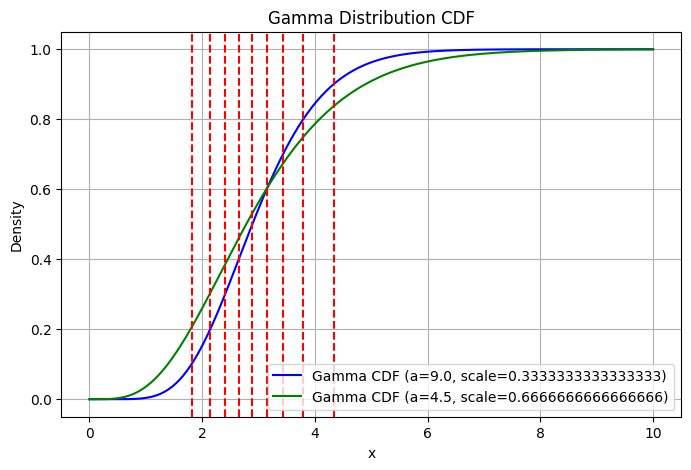

In [ ]:
# Parameters
mu1 = 3
sigma1_sq = 1
mu2 = 3
sigma2_sq = 2

a1 = mu1 * mu1 / sigma1_sq  # Shape parameter
a2 = mu2 * mu2 / sigma2_sq  # Shape parameter
scale1 = sigma1_sq / mu1  # Scale parameter
scale2 = sigma2_sq / mu2  # Scale parameter

x = np.linspace(0, 10, 500)  # Range of x values for the PDF

# Compute the PDFs
cdf_values = gamma.cdf(x, a1, scale=scale1)
cdf_values1 = gamma.cdf(x, a2, scale=scale2)

# Plot the PDFs
plt.figure(figsize=(8, 5))
plt.plot(x, cdf_values, label=f'Gamma CDF (a={a1}, scale={scale1})', color='blue')
plt.plot(x, cdf_values1, label=f'Gamma CDF (a={a2}, scale={scale2})', color='green')

for v in x_qs:
    plt.axvline(x=v, color='red', linestyle='--')

plt.title("Gamma Distribution CDF")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()


In [ ]:
r1 = gamma.rvs(a1, scale=scale1, size=100)

array([2.80862641, 1.7958947 , 3.42316041, 3.02803019, 3.19386846,
       2.76578162, 3.24074937, 4.74693137, 2.56546349, 3.31256571,
       1.41918686, 2.9227673 , 3.27300865, 2.375267  , 2.90803693,
       3.14662732, 2.34405082, 2.34533282, 4.87206632, 2.72884315,
       1.52532525, 1.7245973 , 3.52243442, 2.61701528, 3.6653144 ,
       1.92689633, 2.42330076, 3.90339205, 1.80649027, 2.56094719,
       2.18942422, 3.76011511, 2.07865948, 1.42551013, 4.73775913,
       2.29058147, 3.88910112, 2.30848336, 2.51089172, 3.10275663,
       5.69420252, 2.72655093, 3.87576611, 2.03812132, 2.7348624 ,
       2.78597546, 3.08988836, 3.05890803, 2.60726894, 3.72087242,
       2.10238396, 3.16819836, 3.57376659, 2.30849688, 1.71364866,
       2.78355724, 2.05264586, 2.15715949, 1.62645902, 2.56697701,
       3.56712007, 4.71957319, 5.92304588, 3.45585951, 2.80498368,
       1.56692996, 3.2196331 , 2.58496313, 2.43958902, 2.90905451,
       1.33095016, 1.87100005, 3.9462362 , 2.65371707, 3.32367

In [ ]:
r2 = gamma.rvs(a2, scale=scale2, size=100)

In [ ]:
nll1_1 = -np.log(gamma.pdf(r1, a1, scale=scale1)).sum()
nll1_1

np.float64(134.28262348704197)

In [ ]:
nll1_2 = -np.log(gamma.pdf(r1, a2, scale=scale2)).sum()
nll1_2

np.float64(144.38138922381603)

In [ ]:
nll2_1 = -np.log(gamma.pdf(r2, a1, scale=scale1)).sum()
nll2_1

np.float64(192.6375507707407)

In [ ]:
nll2_2 = -np.log(gamma.pdf(r2, a2, scale=scale2)).sum()
nll2_2

np.float64(171.67007093979487)

In [ ]:
# NLL function for Gamma distribution
def compute_nll_gamma(a1, data, scale):
    """
    Compute the Negative Log-Likelihood (NLL) for the Gamma distribution.
    
    Parameters:
        a1 (float): Shape parameter of the Gamma distribution.
        data (array-like): Data points to compute the NLL for.
        scale (float): Scale parameter of the Gamma distribution.
    
    Returns:
        nll (float): The negative log-likelihood value.
    """
    # Compute the PDF for each data point
    pdf_values = gamma.pdf(data, a1, scale=scale)
    
    # To avoid log(0), use np.clip to ensure we don't take the log of 0
    pdf_values = np.clip(pdf_values, 1e-10, None)
    
    # Compute the negative log-likelihood (sum of the logs of the PDF values)
    nll = -np.sum(np.log(pdf_values))
    
    return nll

In [ ]:
print(compute_nll_gamma(a1, r1, scale1))
print(compute_nll_gamma(a2, r1, scale2))
print(compute_nll_gamma(a1, r2, scale1))
print(compute_nll_gamma(a2, r2, scale2))

134.28262348704197
144.38138922381603
192.6375507707407
171.67007093979487


In [ ]:
nll1_1, nll1_2, nll2_1, nll2_2

(np.float64(134.28262348704197),
 np.float64(144.38138922381603),
 np.float64(192.6375507707407),
 np.float64(171.67007093979487))